## Importing Libraries and Functions

In [1]:
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from datetime import datetime, timedelta, date
import holidays

from prophet import Prophet
from prophet.diagnostics import performance_metrics 
from prophet.plot import plot_cross_validation_metric 
from prophet.diagnostics import cross_validation

## Define Functions

In [2]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    Input:
    -pandas df
    
    Retunrs:
    -pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    
    table = pd.concat([total, percent], axis = 1, keys = ['Null Count', 'Null Percentage'])
    
    types = []
    
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
        
    table["Types"] = types
    
    return(pd.DataFrame(table))


def safe_to_datetime(date):
    '''
    Safely converts a date to datetime format to avoid errors during conversion. 
    If the conversion fails, it returns 'NaT' (Not a Time), ensuring the process continues smoothly.
    
    Parameters:
    - date: The date value to convert (can be a string or other date-like format).
    
    Returns:
    - A datetime object if conversion is successful; otherwise, 'NaT'.
    '''
    try:
        # Attempt to convert the date using the specified format ('%Y-%m-%d')
        return pd.to_datetime(date, format='%Y-%m-%d')
    except Exception:
        # If there's an error during conversion, return 'NaT' to avoid interruptions in processing
        return pd.NaT


def clean_data_percentiles(df, column_name, lower_percentile=0.01, upper_percentile=0.99):
    '''
    Cleans data in the specified column of the DataFrame using percentiles and prints the percentage of data retained.
    
    Input:
    -pandas df
    -column name
    -upper percentail range(0-1)
    -lower percentail range(0-1)

    Returns:
    -pandas df
    
    '''
    initial_count = len(df)
    
    # Calculate the lower and upper bounds
    lower_bound = df[column_name].quantile(lower_percentile)
    upper_bound = df[column_name].quantile(upper_percentile)
    
    # Filter out outliers
    cleaned_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    final_count = len(cleaned_df)
    retention_percentage = (final_count / initial_count) * 100
    
    print(f'Data retained after cleaning: {retention_percentage:.2f}%')
    
    return cleaned_df


def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## Reading in Data

In [3]:
data = pd.read_csv('train.csv')

data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')
data.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

### For the purpose of this work, will be only looking at 2 families - PRODUCE and GROCERY I


In [4]:
data['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [5]:
data = data[data['family'].isin(['PRODUCE', 'GROCERY I'])].copy()
unique_family_groups = data.family.unique()
unique_family_groups

array(['GROCERY I', 'PRODUCE'], dtype=object)

## Exploring Data Quality For Model Building

In [6]:
data.shape

(181872, 6)

In [7]:
data.describe()

id                           date      store_nbr  \
count  1.818720e+05                         181872  181872.000000   
mean   1.500448e+06  2015-04-24 08:27:04.703087872      27.500000   
min    1.200000e+01            2013-01-01 00:00:00       1.000000   
25%    7.502302e+05            2014-02-26 18:00:00      14.000000   
50%    1.500448e+06            2015-04-24 12:00:00      27.500000   
75%    2.250667e+06            2016-06-19 06:00:00      41.000000   
max    3.000885e+06            2017-08-15 00:00:00      54.000000   
std    8.662841e+05                            NaN      15.585827   

               sales    onpromotion  
count  181872.000000  181872.000000  
mean     2563.162112      16.675035  
min         0.000000       0.000000  
25%        48.000000       0.000000  
50%      2000.980000       0.000000  
75%      3721.000000      10.000000  
max    124717.000000     741.000000  
std      2827.400836      37.681247

### Original data is on store level, we would like to have it on family group level to have a more higher volume metric.

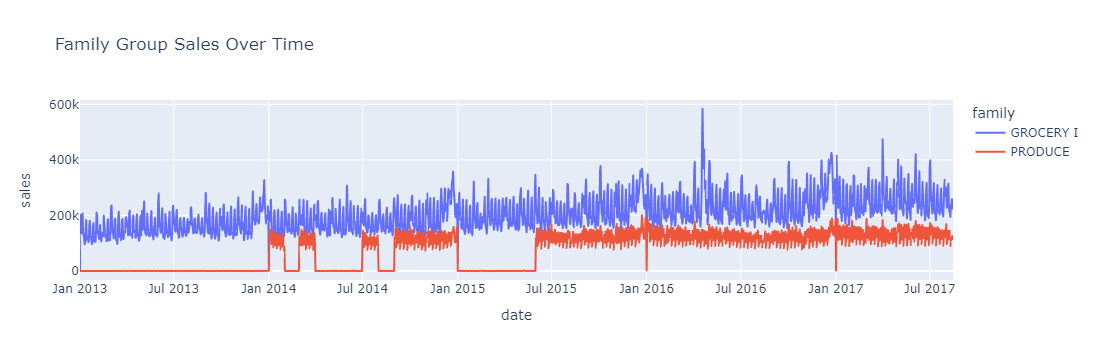

In [8]:
agg_data = data.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family', 'date'])

fig = px.line(agg_data,
              x='date',
              y='sales',
              color='family',
              title = 'Family Group Sales Over Time')
fig.show()

### For forecasting will be using a prophet model that requires the data to be in a format whre both date and the desired metric to be predited are in a column format

* Pivoting the agg_data and plotting trended data for all family groups

In [9]:
total_sales_df = agg_data.pivot(index='date',
                               columns='family',
                               values='sales').reset_index()

total_sales_df.head()

family       date  GROCERY I  PRODUCE
0      2013-01-01      700.0      0.0
1      2013-01-02   202020.0      0.0
2      2013-01-03   144878.0      0.0
3      2013-01-04   135754.0      0.0
4      2013-01-05   188356.0      0.0

### For time series forcasting we want at least 2-3 years worth of quality data.
Thus we will only look at the latest 2 years of data.

In [10]:
total_sales_df['date'].min(), total_sales_df['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [11]:
total_sales_df = total_sales_df[total_sales_df['date']>='2015-08-15']
total_sales_df.head()

family       date   GROCERY I       PRODUCE
954    2015-08-15  280491.477  128147.17800
955    2015-08-16  266657.285  131493.92710
956    2015-08-17  205150.612  102769.59890
957    2015-08-18  181016.014  106468.22500
958    2015-08-19  178550.626  132449.57997

In [12]:
total_sales_df['date'].min(), total_sales_df['date'].max()

(Timestamp('2015-08-15 00:00:00'), Timestamp('2017-08-15 00:00:00'))

## Checking for data types and missing data

In [13]:
# Checking for any missing data profile
missing_data(total_sales_df)

Null Count  Null Percentage           Types
family                                                
date                0              0.0  datetime64[ns]
GROCERY I           0              0.0         float64
PRODUCE             0              0.0         float64

## Uncleaned Trended View and Distribution

In [14]:
unique_family_groups

array(['GROCERY I', 'PRODUCE'], dtype=object)

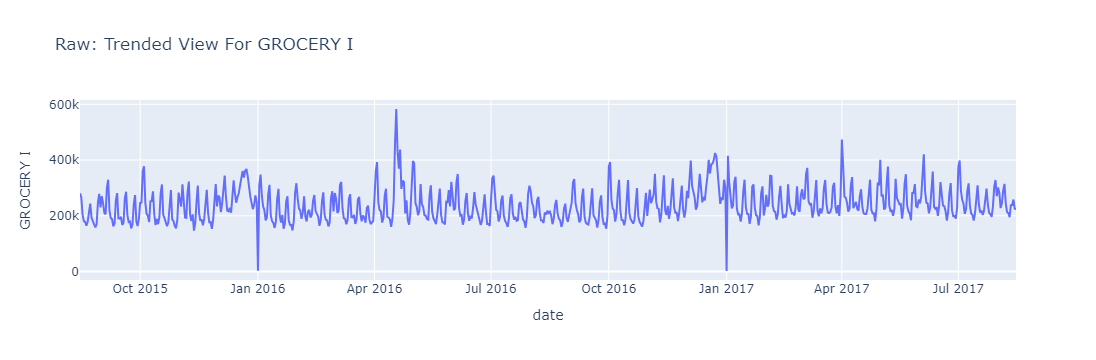

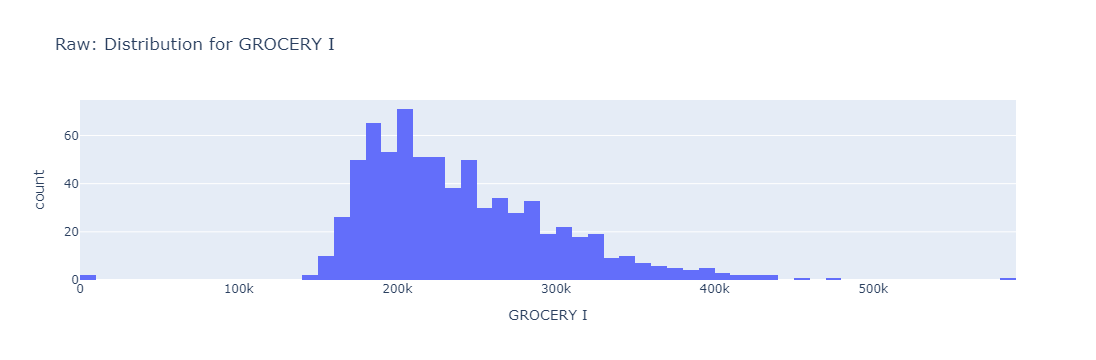

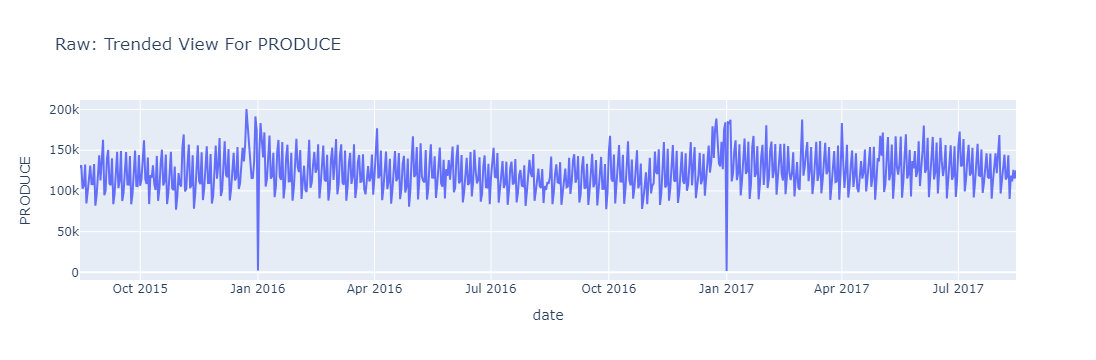

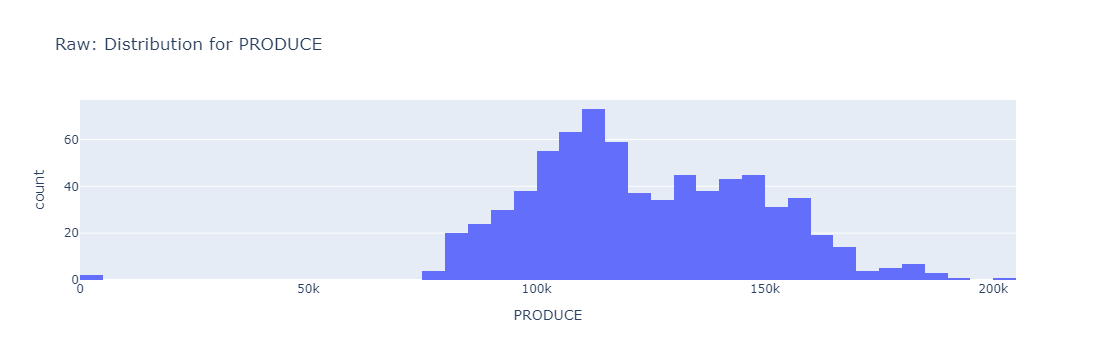

In [15]:
for single_family in unique_family_groups:
    fig = px.line(total_sales_df,
                 x='date',
                 y=single_family,
                 title=f'Raw: Trended View For {single_family}')
    fig_hist = px.histogram(total_sales_df,
                           x=single_family,
                           title=f'Raw: Distribution for {single_family}')
    fig.show()
    fig_hist.show()

## Prophet Model

### Setting up parameters for crossvalidation

In [16]:
changepoint_prior_scale_range = np.linspace(0.002, 0.5, num=5).tolist()
changepoint_prior_scale_range

[0.002, 0.1265, 0.251, 0.3755, 0.5]

In [17]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
seasonality_prior_scale_range

[0.01, 2.5075, 5.005, 7.5024999999999995, 10.0]

In [18]:
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range

[0.01, 2.5075, 5.005, 7.5024999999999995, 10.0]

In [19]:
changepoint_prior_scale_range = np.linspace(0.002, 0.5, num=5).tolist()
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

### Adding in Holidays

In [24]:
holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()
study_range = total_sales_df.date.dt.year.unique()

for date_, name in sorted(holidays.EC(years=study_range).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_,
                                                'holiday': "EC-Holidays",
                                                'lower_window': -2, # include 2 days before to holiday to the effect
                                                'upper_window': 1}, # include 1 days after to the holiday effect
                                                index=[0])], ignore_index=True) 

#holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday['ds'] = holiday['ds'].apply(safe_to_datetime)
holiday.head()

ds      holiday  lower_window  upper_window
0 2015-01-01  EC-Holidays            -2             1
1 2015-02-16  EC-Holidays            -2             1
2 2015-02-17  EC-Holidays            -2             1
3 2015-04-03  EC-Holidays            -2             1
4 2015-05-01  EC-Holidays            -2             1

Data retained after cleaning: 97.81%


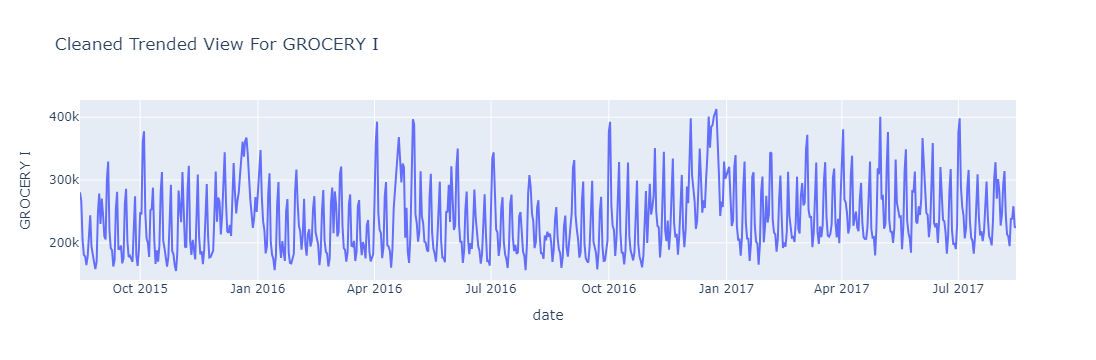

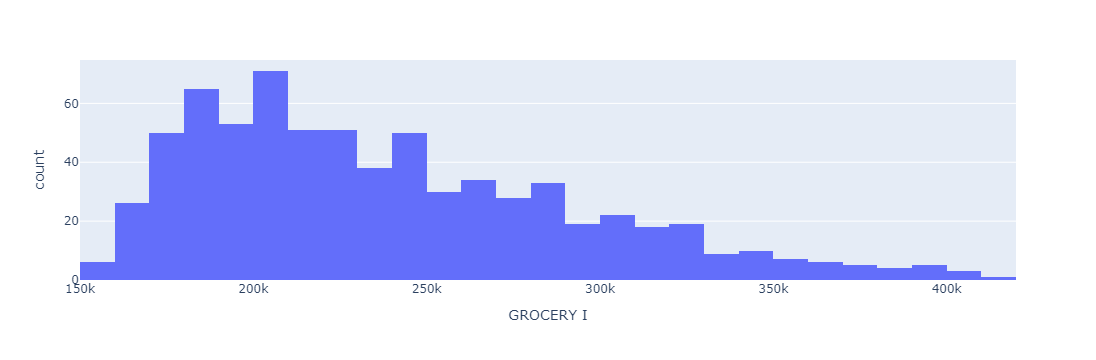

16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:22 - cmdstanpy - INFO - Chain [1] start processing
16:25:23 - cmdstanpy - INFO - Chain [1] done processing
16:25:33 - cmdstanpy - INFO - Chain [1] start processing
16:25:33 - cmdstanpy - INFO - Chain [1] done processing
16:25:42 - cmdstanpy - INFO - Chain [1] start processing
16:25:42 - cmdstanpy - INFO - Chain [1] done processing
16:25:52 - cmdstanpy - INFO - Chain [1] start processing
16:25:52 - cmdstanpy - INFO - Chain [1] done processing
16:26:02 - cmdstanpy - INFO - Chain [1] start processing
16:26:02 - cmdstanpy - INFO - Chain [1] done processing
16:26:12 - cmdstanpy - INFO - Chain [1] start processing
16:26:12 - cmdstanpy - INFO - Chain [1] done processing
16:26:22 - cmdstanpy - INFO - Chain [1] start processing
16:26:22 - cmdstanpy - INFO - Chain [1] done processing
16:26:33 - cmdstanpy - INFO - Chain [1] start processing
16:26:33 - cmdstanpy - INFO - Chain [1]

GROCERY I MAPE: 8.51678468405439
Top 10 by MAPE Value
           ds           yhat       ytrue       mape  overestimate
0  2017-07-01  304684.395829  375440.305  18.846114         False
1  2017-07-02  327026.774051  398356.868  17.906079         False
2  2017-07-03  248588.075583  288954.266  13.969751         False
3  2017-07-04  232351.303765  257414.024   9.736346         False
4  2017-07-05  234044.772569  243726.892   3.972528         False
27 2017-07-28  232944.480232  233685.813   0.317235         False
29 2017-07-30  328699.734572  328519.734  -0.054791          True
28 2017-07-29  306357.356350  303657.532  -0.889102          True
5  2017-07-06  214119.328040  207284.273  -3.297431          True
16 2017-07-17  249424.555844  241417.015  -3.316892          True
Bottom 10 by MAPE Value
           ds           yhat       ytrue       mape  overestimate
12 2017-07-13  214537.568171  182709.476 -17.420056          True
11 2017-07-12  234463.012699  203237.328 -15.364148          Tru

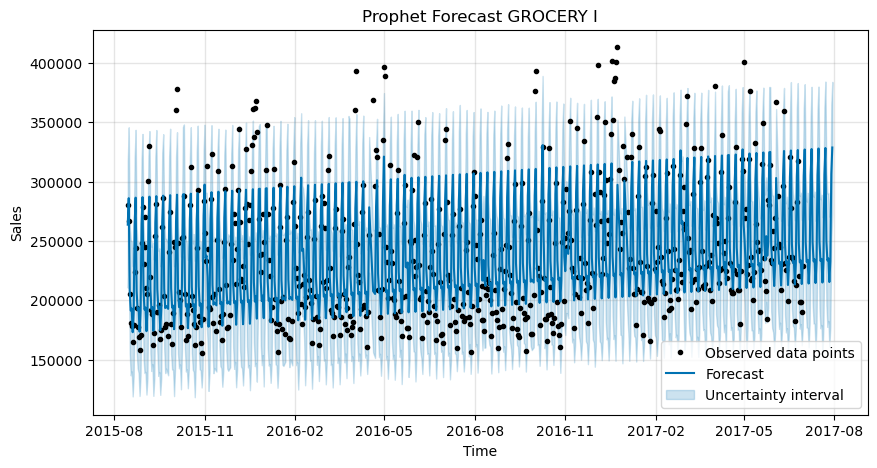

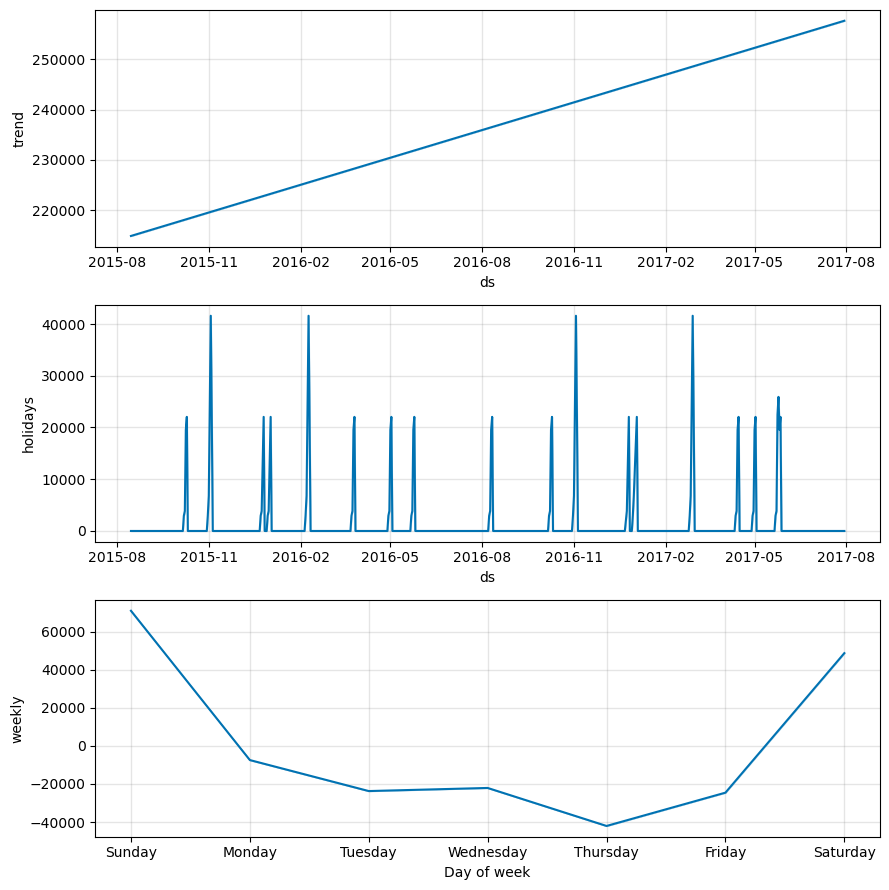

Data retained after cleaning: 97.81%


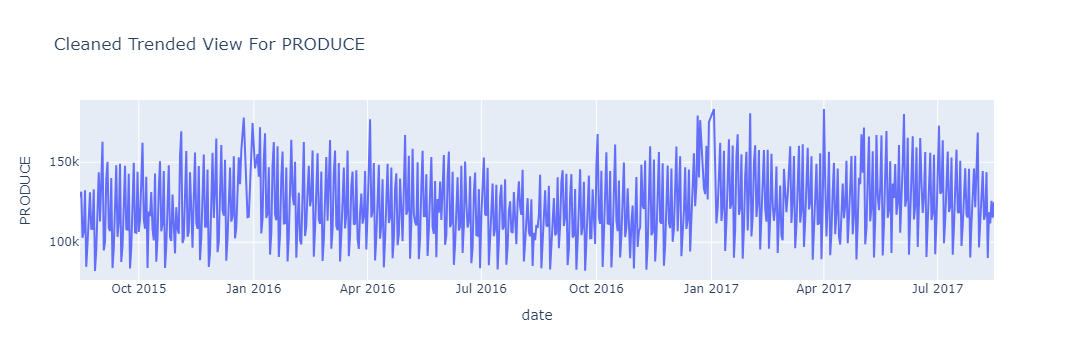

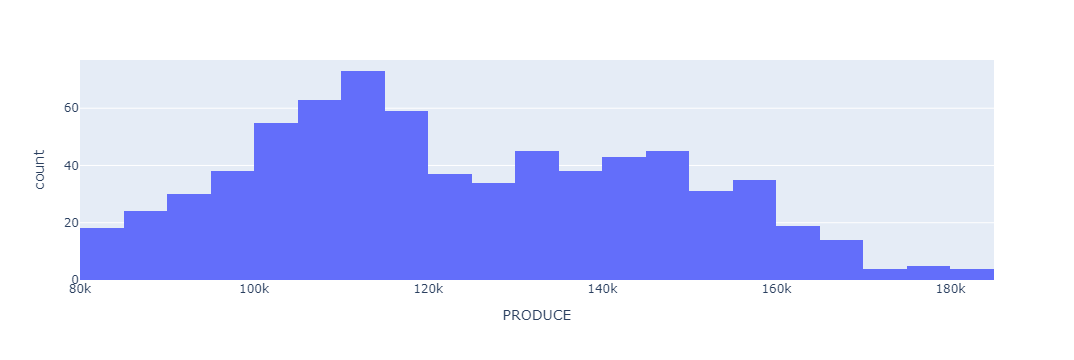

16:44:33 - cmdstanpy - INFO - Chain [1] start processing
16:44:33 - cmdstanpy - INFO - Chain [1] done processing
16:44:42 - cmdstanpy - INFO - Chain [1] start processing
16:44:42 - cmdstanpy - INFO - Chain [1] done processing
16:44:52 - cmdstanpy - INFO - Chain [1] start processing
16:44:52 - cmdstanpy - INFO - Chain [1] done processing
16:45:03 - cmdstanpy - INFO - Chain [1] start processing
16:45:03 - cmdstanpy - INFO - Chain [1] done processing
16:45:12 - cmdstanpy - INFO - Chain [1] start processing
16:45:13 - cmdstanpy - INFO - Chain [1] done processing
16:45:23 - cmdstanpy - INFO - Chain [1] start processing
16:45:23 - cmdstanpy - INFO - Chain [1] done processing
16:45:32 - cmdstanpy - INFO - Chain [1] start processing
16:45:32 - cmdstanpy - INFO - Chain [1] done processing
16:45:41 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] done processing
16:45:52 - cmdstanpy - INFO - Chain [1] start processing
16:45:52 - cmdstanpy - INFO - Chain [1]

PRODUCE MAPE: 4.062538489753194
Top 10 by MAPE Value
           ds           yhat         ytrue       mape  overestimate
1  2017-07-02  151359.796411  172890.13860  12.453193         False
0  2017-07-01  138225.847122  155487.63090  11.101709         False
2  2017-07-03  116362.513830  130389.19902  10.757551         False
3  2017-07-04  122135.983562  131534.54802   7.145320         False
4  2017-07-05  153155.364724  163804.33003   6.501028         False
15 2017-07-16  151529.220139  157883.05600   4.024394         False
8  2017-07-09  151444.508275  156633.92050   3.313083         False
6  2017-07-07  111755.933131  114346.57410   2.265604         False
16 2017-07-17  116531.937558  119026.44020   2.095755         False
9  2017-07-10  116447.225694  118856.99105   2.027449         False
Bottom 10 by MAPE Value
           ds           yhat         ytrue      mape  overestimate
26 2017-07-27   98492.878299   90481.28610 -8.854419          True
12 2017-07-13   98323.454571   92111.2730

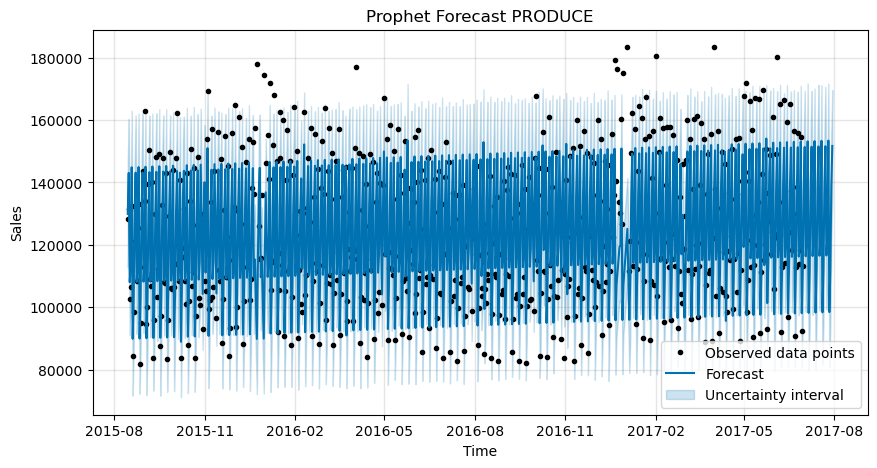

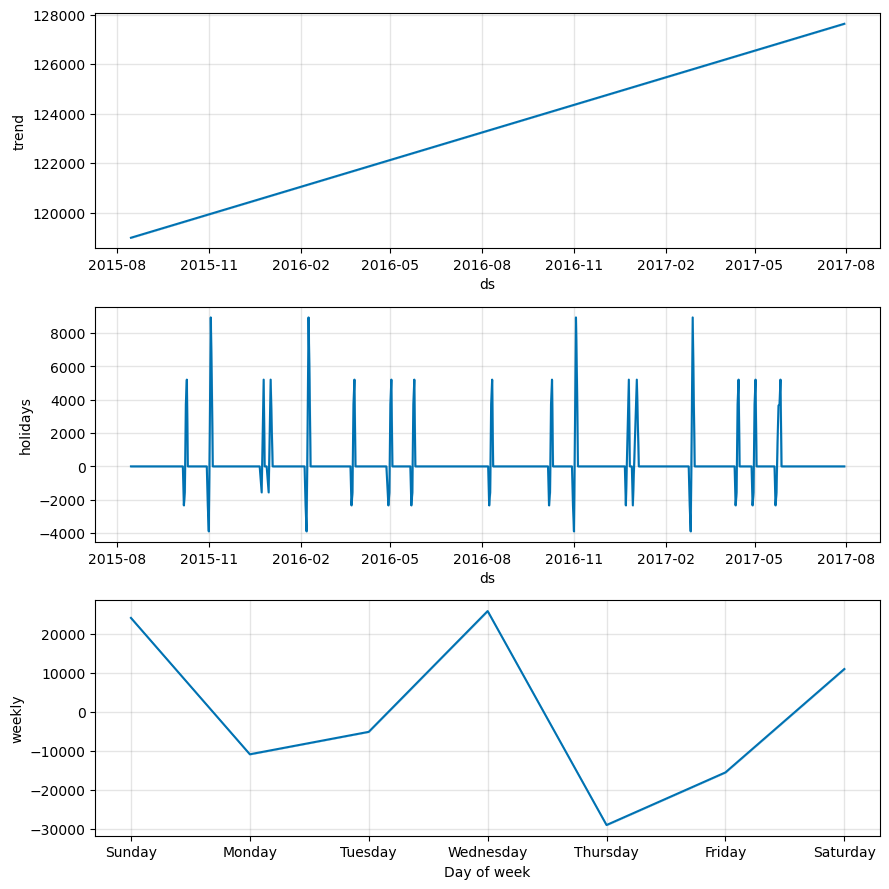

In [21]:
# Iterate directly over the features in unique_family_groups
for feature in unique_family_groups:
    
    ## Step 1: Cleaning of data and defining the model data
    feature_sales = total_sales_df[['date', feature]]
    feature_cleaned = clean_data_percentiles(feature_sales, feature)
    model_data = feature_cleaned

    # Step 2: Plotting of the data
    fig = px.line(feature_cleaned, x='date', y=feature, title = f'Cleaned Trended View For {feature}')
    fig_hist = px.histogram(feature_cleaned, x=feature)
    fig.show()
    fig_hist.show()

    ## Step 3: Forecasting time window
    prediction_days = 30  # Predicting 30 days
    forecast_start_dt = date(2017, 7, 1)  # Example fixed start date
    forecast_start_date = forecast_start_dt.strftime("%Y-%m-%d")

    ## Step 4: Finding the model with the lowest error
    # Prepare data for Prophet
    df_copy = model_data.copy()
    df_copy = df_copy.rename(columns={'date': 'ds', feature: 'y'})
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)
    df_copy['ds'] = pd.to_datetime(df_copy['ds'])

    # Split into training data based on the forecast start date
    train_set = df_copy[df_copy['ds'] < forecast_start_date]

    # Grid search for optimal parameters using cross-validation
    param_grid = {
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range,
        'holidays_prior_scale': holidays_prior_scale_range,
    }
    
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = []
    all_df_cvs = []

    # Step 5: Model tuning and cross-validation for each parameter combination
    for params in all_params:
        m = Prophet(**params).fit(train_set)
        df_cv = cross_validation(m, initial='365 days', period='30 days', horizon='30 days', parallel='processes')
        df_p = performance_metrics(df_cv, rolling_window=1)
        mapes.append(df_p["mape"].values[0])
        df_cv['mapes'] = df_p["mape"].values[0]
        all_df_cvs.append(df_cv)

    # Step 6: Identify the best parameters based on MAPE
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    params_dictionary = dict(tuning_results.sort_values('mape').reset_index(drop=True).drop('mape', axis='columns').iloc[0])

    ## Step 7: Fit the model with the optimal parameters
    model = Prophet(
        changepoint_prior_scale=params_dictionary['changepoint_prior_scale'],
        seasonality_prior_scale=params_dictionary['seasonality_prior_scale'],
        holidays_prior_scale=params_dictionary['holidays_prior_scale'],
        holidays=holiday
    )
    model.fit(train_set)

    # Step 8: Make predictions
    future = model.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = model.predict(future)
    filtered_fcst_prophet_train = fcst_prophet_train[fcst_prophet_train['ds'] >= forecast_start_date]
    predicted_df = filtered_fcst_prophet_train[['ds', 'yhat']]

    df_copy = model_data.copy()
    df_copy.columns = ['ds', 'ytrue']
    predicted_df = predicted_df.merge(df_copy, on='ds')

    # Step 9: Calculate MAPE and overestimate metrics
    mape_value = mape(predicted_df['ytrue'], predicted_df['yhat'])
    print(f'{feature} MAPE: {mape_value}')
    predicted_df['mape'] = (predicted_df['ytrue'] - predicted_df['yhat']) / predicted_df['ytrue'] * 100
    predicted_df['overestimate'] = predicted_df['yhat'] > predicted_df['ytrue']

    # Display top 10 and bottom 10 by MAPE value
    print('Top 10 by MAPE Value')
    print(predicted_df.sort_values('mape', ascending=False).head(10))

    print('Bottom 10 by MAPE Value')
    print(predicted_df.sort_values('mape', ascending=True).head(10))

    # Step 10: Visualize forecast results
    fig, ax = plt.subplots(figsize=(10, 5))
    model.plot(fcst_prophet_train, ax=ax)
    ax.set_title(f'Prophet Forecast {feature}')
    ax.set_ylabel('Sales')
    ax.set_xlabel('Time')
    plt.legend()
    plt.show()

    # Plot the components of the forecast
    fig = model.plot_components(fcst_prophet_train)
    plt.show()
